In [1]:
import sys
import os
IMATOOLS_DIR = os.getcwd()+'/..'
sys.path.insert(1, IMATOOLS_DIR)

import pandas as pd 
import numpy as np


In [2]:
from imatools.common import ioutils as iou 

# Locations of hard drive based on platform
dirdic={'macOS'   : '/Volumes/sandisk', 
        'Linux'   : '/media/jsl19/sandisk' , 
        'Windows' : 'D:/'}

p2f = iou.fullfile(dirdic[iou.chooseplatform()], '09-dnav_vs_inav/umc')
name = 'spatial_correspondence.csv'

df = pd.read_csv(iou.fullfile(p2f, 'local',name), skipinitialspace=True)
df_stats = pd.read_csv(iou.fullfile(p2f, 'results_local', 'stats.csv'), skipinitialspace=True)

In [4]:
df_stats

,CASE,LGE_TYPE,MEAN_BP,SDEV_BP,FIB_SCORE
0,2,dNAV,98.8123,11.94290,11.966000
1,2,iNAV,78.9256,11.17400,13.486200
2,5,dNAV,78.5036,7.53802,21.848700
3,5,iNAV,73.5618,7.44408,15.653200
4,6,dNAV,79.7279,10.26780,18.264200
5,6,iNAV,54.2140,6.74873,10.335300
6,7,dNAV,58.5881,10.26830,41.157900
7,7,iNAV,52.6810,5.92970,27.126400
8,8,dNAV,79.2482,7.79663,7.560920
9,8,iNAV,68.7854,8.10349,11.999500


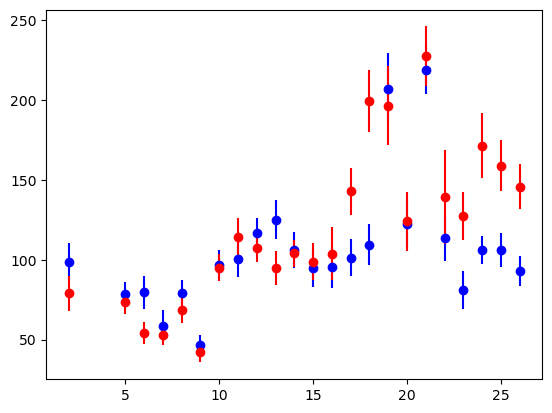

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

xx = True

if xx : 
    plt.errorbar(data=df_stats[df_stats['LGE_TYPE']=='dNAV'], x='CASE', y='MEAN_BP', yerr='SDEV_BP', fmt='ob')
    plt.errorbar(data=df_stats[df_stats['LGE_TYPE']=='iNAV'], x='CASE', y='MEAN_BP', yerr='SDEV_BP', fmt='or')
else :
    sns.scatterplot(data=df_stats, x='CASE', y='FIB_SCORE ', hue='LGE_TYPE')

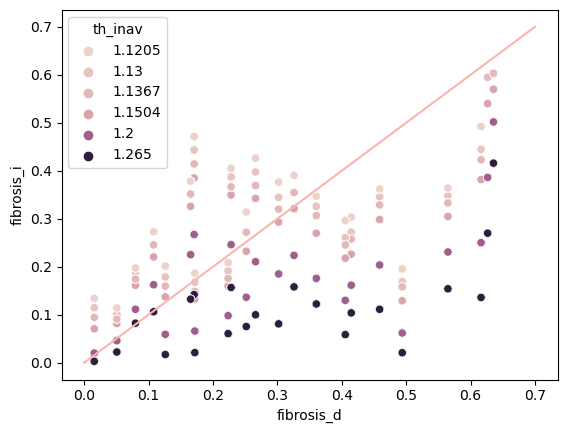

In [75]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

x=np.linspace(0, 0.7, 10)
y=x

sns.set_palette(palette='Pastel1')
sns.scatterplot(data=df, x='fibrosis_d', y='fibrosis_i', hue='th_inav', hue_order=[1.1205, 1.13, 1.1367, 1.1504, 1.2, 1.265])
plt.plot(x,y)


Text(0, 0.5, 'iNAV Fibrosis %')

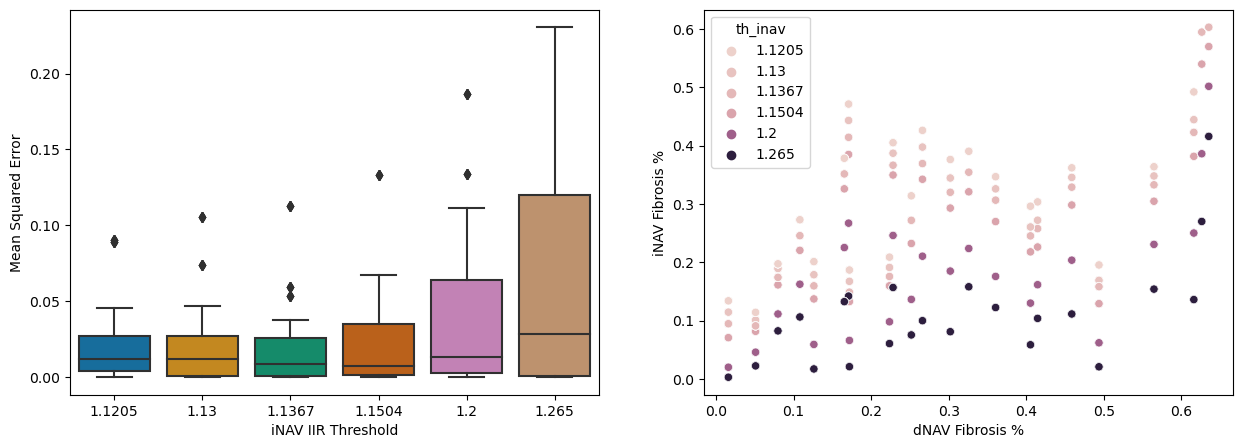

In [8]:

fig, ax = plt.subplots(1,2)
fig.set_figheight(5)
fig.set_figwidth(15)
sns.set_palette('Pastel1')

sns.boxplot(ax=ax[0], x=df['th_inav'], y=(df['fibrosis_d']-df['fibrosis_i'])
            ** 2, order=[1.1205, 1.13, 1.1367, 1.1504, 1.2, 1.265], 
            whis=1)
sns.scatterplot(ax=ax[1], data=df, x='fibrosis_d', y='fibrosis_i', hue='th_inav', hue_order=[1.1205, 1.13, 1.1367, 1.1504, 1.2, 1.265])
plt.plot()

ax[0].set_xlabel('iNAV IIR Threshold')
ax[0].set_ylabel('Mean Squared Error')
ax[1].set_xlabel('dNAV Fibrosis %')
ax[1].set_ylabel('iNAV Fibrosis %')

# sns.lmplot( data=df, x='fibrosis_d', y='fibrosis_i', col='th_inav', col_order=[1.1205, 1.13, 1.1367, 1.1504, 1.2, 1.265])

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


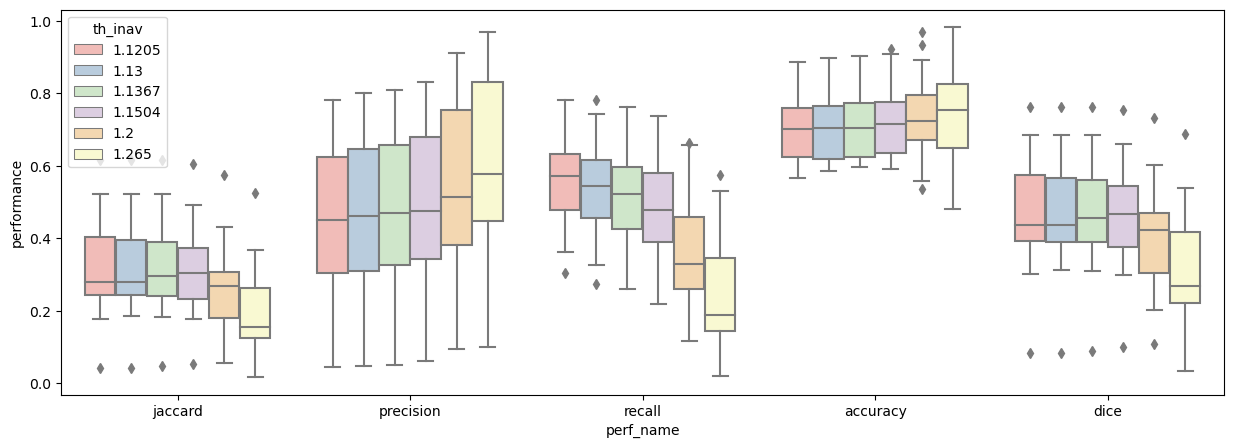

In [66]:

fig, ax = plt.subplots(1)
fig.set_figheight(5)
fig.set_figwidth(15)
sns.set_palette('Pastel1')
sns.boxplot(ax=ax, data=df, 
    x='perf_name', y='performance', hue='th_inav', whis=1,
    hue_order=[1.1205, 1.13, 1.1367, 1.1504, 1.2, 1.265])

plt.savefig(iou.fullfile(p2f, 'performance.eps'))


In [72]:
metric_name = 'accuracy'
th = [1.1205, 1.13, 1.1367, 1.1504, 1.2, 1.265]

print(metric_name)
for threshold in th :
    # threshold = 1.1205
    metric = df['performance']
    thresh = df['th_inav']

    metric = metric[df['perf_name']==metric_name]
    thresh = thresh[df['perf_name']==metric_name]

    metric = metric[thresh==threshold]

    print('{:.3f} (+/-{:.3f})'.format(np.mean(metric), np.std(metric)))


accuracy
0.702 (+/-0.086)
0.708 (+/-0.089)
0.714 (+/-0.092)
0.719 (+/-0.098)
0.733 (+/-0.118)
0.734 (+/-0.138)
